#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3;

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
project_dir = 'F:/Project_Data/Project_9'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
tb_species = 'NC_000962.3' 
sample_filenames = ['GCF_000195955.2_ASM19595v2_genomic.gbff', 'GCF_024600175.1_ASM2460017v1_genomic.gbff', 'GCF_010730055.1_ASM1073005v1_genomic.gbff', 'GCF_020616615.1_ASM2061661v1_genomic.gbff', 'GCF_010731535.1_ASM1073153v1_genomic.gbff',
                    'GCF_022370755.1_ASM2237075v1_genomic.gbff', 'GCF_016745295.1_ASM1674529v1_genomic.gbff', 'GCF_000157895.3_ASM15789v2_genomic.gbff', 'GCF_900603025.1_MHAS_genomic.gbff', 'GCF_018363015.1_ASM1836301v1_genomic.gbff',
                    'GCF_019645855.1_ASM1964585v1_genomic.gbff', 'GCF_010727945.1_ASM1072794v1_genomic.gbff', 'GCF_010731895.1_ASM1073189v1_genomic.gbff', 'GCF_900637205.1_50279_G01_genomic.gbff', 'GCF_000184435.1_ASM18443v1_genomic.gbff']
tb_reannotation_filename = 'annot.gbk'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
min_intergenic_length = 50

#### Find all (maximal nested) ORFs for all species in sample

In [3]:
orf_dict = {}
organism_name_dict = {}
for filename in tqdm(sample_filenames):
    record = next(SeqIO.parse(seq_dir + '/' + filename, "genbank"))
    organism_name = record.annotations['organism']
    accession_ver = record.annotations['accessions'][0] + '.' + str(record.annotations['sequence_version'])
    sequence = str(record.seq)
    ORFFinder = orffn.ORF_Finder(sequence)
    orfs = ORFFinder.max_orf(0, len(sequence), output_orfs = 'Nested', min_orf_length = 50)
    orf_dict[accession_ver] = (sequence, orfs)
    organism_name_dict[accession_ver] = organism_name

100%|██████████| 15/15 [02:19<00:00,  9.31s/it]


#### Set up dataframe with annotated (based on PGP run) M.tb feature boundaries and Mycobrowser M.tb feature boundaries

In [4]:
xls = pd.ExcelFile('F:/Datasets/Data_From_Publications/Mycobrowser_Release_4.xlsx')
mycobrowser_df = pd.read_excel(xls)
genbank_cds_boundaries = []
mycobrowser_cds_boundaries = []
mycobrowser_feature_boundaries = []
for genome_record in SeqIO.parse(project_dir + '/' + tb_reannotation_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type not in ('source', 'gene'):
            a = feature.qualifiers  
            genbank_cds_boundaries.append((int(feature.location.start), int(feature.location.end), int(feature.location.strand))) 

for i,r in mycobrowser_df.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    if r['Feature'] == 'CDS':
        mycobrowser_cds_boundaries.append((r['Start']-1,r['Stop'], strand, r['Stop'] - r['Start']))
    mycobrowser_feature_boundaries.append((r['Start']-1,r['Stop'], strand, r['Stop'] - r['Start']))

#### Find non-nested ORFs in mycobrowser inter-feature regions - candidate novel ORFs

In [28]:
mycobrowser_inter_feature_orfs = []
mycobrowser_feature_boundaries.sort(key = lambda x: x[1])
mycobrowser_inter_feature_orf_probabilities = []
max_stop = 0
tb_sequence = orf_dict[tb_species][0]
ORFFinder = orffn.ORF_Finder(tb_sequence)
for i, (start, stop, strand, length) in enumerate(mycobrowser_feature_boundaries):
    if i < len(mycobrowser_feature_boundaries) - 1:
        max_stop = max(stop, max_stop)
        if mycobrowser_feature_boundaries[i+1][1] > max_stop + min_intergenic_length:
            a =ORFFinder.max_orf(max_stop-5, mycobrowser_feature_boundaries[i+1][1]+5, output_orfs = 'Nested', min_orf_length = 50)
            for x in a:
                mycobrowser_inter_feature_orfs.append(x)
max_stop = 0
H37Rv_ORFFinder = orffn.H37Rv_ORF_Finder()
for i, (start, stop, strand, length) in enumerate(mycobrowser_feature_boundaries):
    if i < len(mycobrowser_feature_boundaries) - 1:
        max_stop = max(stop, max_stop)
        if mycobrowser_feature_boundaries[i+1][1] > max_stop + min_intergenic_length:
            a =H37Rv_ORFFinder.max_orf(max_stop-5, mycobrowser_feature_boundaries[i+1][1]+5, 999, output_orfs = 'Nested', min_orf_length = 50)
            for x in a:
                mycobrowser_inter_feature_orf_probabilities.append(x)

In [34]:
len(mycobrowser_inter_feature_orfs)

58182

<AxesSubplot:ylabel='Count'>

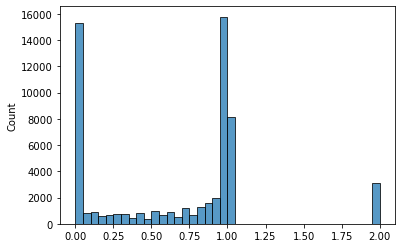

In [30]:
sns.histplot([x[4] for x in mycobrowser_inter_feature_orf_probabilities])

In [6]:
mycobrowser_inter_feature_orfs_dict = {}
mycobrowser_inter_feature_orfs_dict[tb_species] = (orf_dict[tb_species][0], mycobrowser_inter_feature_orfs)
mycobrowser_cds_dict = {}
mycobrowser_cds_dict[tb_species] = (orf_dict[tb_species][0], [x for x in mycobrowser_cds_boundaries])

In [35]:
mycobrowser_inter_feature_orfs

#### Produce FASTA file with CDS candidates

In [7]:
def produce_orf_protein_fasta_file(orf_dict, output_file):
    trans = util.Translator()
    temp = []
    for k, v in orf_dict.items():
        full_sequence = v[0]
        orf_list = v[1]
        for x in orf_list:
            if x[2] == 1:
                prot = trans.translate_sequence(full_sequence[x[0]:x[1]], 1, 0)
            else:
                prot = trans.translate_sequence(util.reverse_complement(full_sequence[x[0]:x[1]]), 1, 0)
            name = k + '@' +str(x[0])+'_'+str(x[1])+'_'+str(x[2])
            temp.append([name, prot[:-1]])
    util.produce_fasta_file(temp, output_file)

In [ ]:
produce_orf_protein_fasta_file(orf_dict, project_dir + '/comparator_orfs.fasta')

In [36]:
produce_orf_protein_fasta_file(mycobrowser_inter_feature_orfs_dict, project_dir + '/mycobrowser_inter_feature_orfs.fasta')

100%|██████████| 58182/58182 [00:01<00:00, 38316.48it/s] 


In [ ]:
produce_orf_protein_fasta_file(mycobrowser_cds_dict, project_dir + '/mycobrowser_cds.fasta')

In [ ]:
blastfn.build_blast_db(project_dir, 'comparator_orfs.fasta', 'comparator_orfs', 'F:/Datasets/BLAST/comparator_orfs')
blastfn.build_blast_db(project_dir, 'mycobrowser_inter_feature_orfs.fasta', 'mycobrowser_inter_feature_orfs', 'F:/Datasets/BLAST/mycobrowser_inter_feature_orfs')

In [ ]:
blastfn.run_blastp('F:/Datasets/BLAST/comparator_orfs', 'mycobrowser_cds.fasta', 'comparator_orfs', 'hits.csv', e_value = 1e-10)

In [74]:
blastfn.run_blastp('F:/Datasets/BLAST/comparator_orfs', 'mycobrowser_inter_feature_orfs.fasta', 'comparator_orfs', 'if_hits.csv', e_value = 0.001)

#### Analyse CDS orthologs in target species

In [15]:
blast_output = blastfn.process_blast_output('F:/Datasets/BLAST/comparator_orfs/hits.csv', organism_name_dict, top_hit_only = False)

In [124]:
neighbour_dict = {}
homolog_dict = {}
test = blast_output[blast_output['target_species_name'] == 'Mycobacterium kansasii ATCC 12478'];
test['num_identical_matches'] = test['alignment_length'] * test['percent_identical_matches']/100;
test['max_identical_query_matches'] = test.groupby('query_ref')['num_identical_matches'].transform('max');
test['max_identical_target_matches'] = test.groupby('target_ref')['num_identical_matches'].transform('max');
test = test[test['num_identical_matches']>0.8*test['max_identical_query_matches']]
test = test[test['num_identical_matches']>0.8*test['max_identical_target_matches']]
test = test[test['percent_identical_matches'] > 0]
test['count_matches'] = test.groupby('query_ref')['target_ref'].transform('count');

query_refs = []
target_refs = []
for i, r in test.iterrows():
    test.at[i,'tb_start'] = int(r['query_ref'].split('@')[1].split('_')[0])
    test.at[i,'target_start'] = int(r['target_ref'].split('@')[1].split('_')[0])
    if r['query_ref'] in homolog_dict:
        homolog_dict[r['query_ref']].append(r['target_ref'])
    else:
        homolog_dict[r['query_ref']] = [r['target_ref']]
    query_refs.append(r['query_ref'])
    target_refs.append(r['target_ref'])
query_refs = list(set(query_refs))
query_refs.sort(key = lambda x: int(x.split('@')[1].split('_')[0]))
target_refs = list(set(target_refs))
target_refs.sort(key = lambda x: int(x.split('@')[1].split('_')[0]))
for i, x in enumerate(target_refs):
    if i==0:
        neighbour_dict[x] = ('',target_refs[i+1])
    elif i==len(target_refs)-1:
        neighbour_dict[x] = (target_refs[i-1], '')
    else:
        neighbour_dict[x] = (target_refs[i-1],target_refs[i+1])
for i, x in enumerate(query_refs):
    if i==0:
        neighbour_dict[x] = ('',query_refs[i+1])
    elif i==len(query_refs)-1:
        neighbour_dict[x] = (query_refs[i-1], '')
    else:
        neighbour_dict[x] = (query_refs[i-1],query_refs[i+1])

In [145]:
temp = []
for i, query_ref in enumerate(query_refs):
    matched = 0
    if i == len(query_refs)-1:
        break
    else:
        query_pair = (query_ref, query_refs[i+1])
        if not(query_pair[0] in homolog_dict) or not(query_pair[1] in homolog_dict):
            continue
        else:
            homologs_pair = (homolog_dict[query_pair[0]], homolog_dict[query_pair[1]])
            for homolog_1 in homologs_pair[0]:
                if not(homolog_1 in neighbour_dict):
                    continue
                else:
                    neighbours = neighbour_dict[homolog_1]
                    for homolog_2 in homologs_pair[1]:
                        if homolog_2 == neighbours[0]:
                            matched = 1
                            match = (homolog_1, neighbours[0])
                            break
                        if homolog_2 == neighbours[1]:
                            matched = 1
                            match = (homolog_1, neighbours[1])
                            break
                    if matched == 1:
                        break
        if matched == 1:
            #print(query_pair, match)
            temp.append([query_pair[0], query_pair[1], match[0], match[1]])
temp_df = pd.DataFrame(temp, columns = ['query_1','query_2','target_1', 'target_2'])
for i, r in temp_df.iterrows():
    temp_df.at[i, 'query_species'] = r['query_1'].split('@')[0]
    temp_df.at[i, 'target_species'] = r['target_1'].split('@')[0]
    temp_df.at[i,'query_1_start'] = int(r['query_1'].split('@')[1].split('_')[0])
    temp_df.at[i,'query_1_stop'] = int(r['query_1'].split('@')[1].split('_')[1])
    temp_df.at[i,'query_1_strand'] = int(r['query_1'].split('@')[1].split('_')[2])
    temp_df.at[i,'query_2_start'] = int(r['query_2'].split('@')[1].split('_')[0])
    temp_df.at[i,'query_2_stop'] = int(r['query_2'].split('@')[1].split('_')[1])
    temp_df.at[i,'query_2_strand'] = int(r['query_2'].split('@')[1].split('_')[2])
    temp_df.at[i,'target_1_start'] = int(r['target_1'].split('@')[1].split('_')[0])
    temp_df.at[i,'target_1_stop'] = int(r['target_1'].split('@')[1].split('_')[1])
    temp_df.at[i,'target_1_strand'] = int(r['target_1'].split('@')[1].split('_')[2])
    temp_df.at[i,'target_2_start'] = int(r['target_2'].split('@')[1].split('_')[0])
    temp_df.at[i,'target_2_stop'] = int(r['target_2'].split('@')[1].split('_')[1])
    temp_df.at[i,'target_2_strand'] = int(r['target_2'].split('@')[1].split('_')[2])
    temp_df.at[i,'query_sequence'] = orf_dict[r['query_1'].split('@')[0]][0][int(r['query_1'].split('@')[1].split('_')[0]) : int(r['query_2'].split('@')[1].split('_')[1])]
print(len(temp_df))

2488


In [146]:
temp_df

,query_1,query_2,target_1,target_2,query_species,target_species,query_1_start,query_1_stop,query_1_strand,query_2_start,query_2_stop,query_2_strand,target_1_start,target_1_stop,target_1_strand,target_2_start,target_2_stop,target_2_strand,query_sequence
0,NC_000962.3@0_1524_1,NC_000962.3@2051_3260_1,NC_022663.1@3239554_3241171_1,NC_022663.1@3241681_3242881_1,NC_000962.3,NC_022663.1,0.0,1524.0,1.0,2051.0,3260.0,1.0,3239554.0,3241171.0,1.0,3241681.0,3242881.0,1.0,TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...
1,NC_000962.3@2051_3260_1,NC_000962.3@3279_4437_1,NC_022663.1@3241681_3242881_1,NC_022663.1@3242901_3244068_1,NC_000962.3,NC_022663.1,2051.0,3260.0,1.0,3279.0,4437.0,1.0,3241681.0,3242881.0,1.0,3242901.0,3244068.0,1.0,ATGGACGCGGCTACGACAAGAGTTGGCCTCACCGACTTGACGTTTC...
2,NC_000962.3@3279_4437_1,NC_000962.3@4433_4997_1,NC_022663.1@3242901_3244068_1,NC_022663.1@3244064_3244619_1,NC_000962.3,NC_022663.1,3279.0,4437.0,1.0,4433.0,4997.0,1.0,3242901.0,3244068.0,1.0,3244064.0,3244619.0,1.0,GTGTACGTCCGTCATTTGGGGCTGCGTGACTTCCGGTCCTGGGCAT...
3,NC_000962.3@4433_4997_1,NC_000962.3@5239_7267_1,NC_022663.1@3244064_3244619_1,NC_022663.1@3244875_3246903_1,NC_000962.3,NC_022663.1,4433.0,4997.0,1.0,5239.0,7267.0,1.0,3244064.0,3244619.0,1.0,3244875.0,3246903.0,1.0,ATGACGGGTTCTGTTGACCGGCCCGACCAGAATCGCGGTGAGCGAT...
4,NC_000962.3@5239_7267_1,NC_000962.3@7301_9818_1,NC_022663.1@3244875_3246903_1,NC_022663.1@3247942_3251716_1,NC_000962.3,NC_022663.1,5239.0,7267.0,1.0,7301.0,9818.0,1.0,3244875.0,3246903.0,1.0,3247942.0,3251716.0,1.0,GTGGCTGCCCAGAAAAAGAAGGCCCAAGACGAATACGGCGCTGCGT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,NC_000962.3@4407527_4408202_-1,NC_000962.3@4408333_4408897_-1,NC_022663.1@3235544_3236291_-1,NC_022663.1@3236393_3236972_-1,NC_000962.3,NC_022663.1,4407527.0,4408202.0,-1.0,4408333.0,4408897.0,-1.0,3235544.0,3236291.0,-1.0,3236393.0,3236972.0,-1.0,TCACGCCGTCCCTCCACTCGCCATCCGTGCCGACCCTCGGGCGATC...
2484,NC_000962.3@4408333_4408897_-1,NC_000962.3@4408968_4410069_-1,NC_022663.1@3236393_3236972_-1,NC_022663.1@3237079_3238225_-1,NC_000962.3,NC_022663.1,4408333.0,4408897.0,-1.0,4408968.0,4410069.0,-1.0,3236393.0,3236972.0,-1.0,3237079.0,3238225.0,-1.0,CTAGTCGCGGAGCACAACGACTCGGCGTTCTGGCTCCACGCCTTCG...
2485,NC_000962.3@4408968_4410069_-1,NC_000962.3@4410052_4410415_-1,NC_022663.1@3237079_3238225_-1,NC_022663.1@3238208_3238667_-1,NC_000962.3,NC_022663.1,4408968.0,4410069.0,-1.0,4410052.0,4410415.0,-1.0,3237079.0,3238225.0,-1.0,3238208.0,3238667.0,-1.0,TCAACGTTTGCGTTTTTTCGGTCGCACCCCGGGCCGCGGCGTACGG...
2486,NC_000962.3@4410052_4410415_-1,NC_000962.3@4410411_4410789_-1,NC_022663.1@3238208_3238667_-1,NC_022663.1@3238546_3238909_-1,NC_000962.3,NC_022663.1,4410052.0,4410415.0,-1.0,4410411.0,4410789.0,-1.0,3238208.0,3238667.0,-1.0,3238546.0,3238909.0,-1.0,TCAAACAAAAGACTCACGCTCCCCTCGCTTTGACGCAGGGTTCCAG...


<AxesSubplot:xlabel='query_1_start', ylabel='target_1_start'>

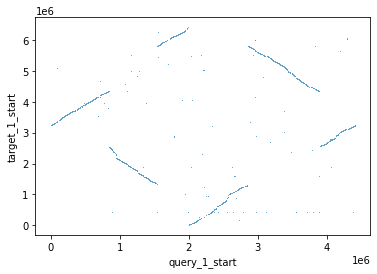

In [126]:
sns.scatterplot(data = temp_df, x = 'query_1_start', y = 'target_1_start', s=1)

In [79]:
test.to_csv(project_dir + '/test.csv')

<AxesSubplot:xlabel='tb_start', ylabel='target_start'>

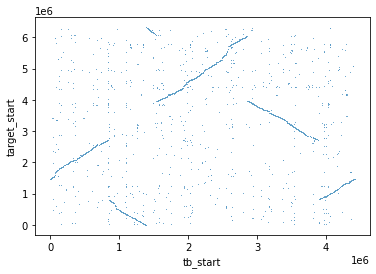

In [117]:
sns.scatterplot(data = test, x  = 'tb_start', y = 'target_start', s=1 )

<AxesSubplot:xlabel='percent_identical_matches', ylabel='Count'>

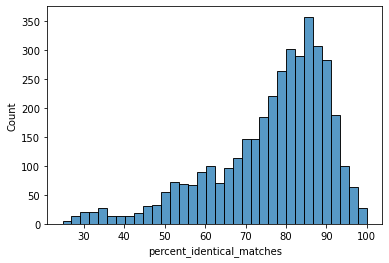

In [116]:
sns.histplot(data = test, x = 'percent_identical_matches')

#### Analyse interfeature orthologs in target species

In [38]:
prob_dict = {}
for (start, stop, strand, length, prob) in mycobrowser_inter_feature_orf_probabilities:
    prob_dict[(start, stop, strand)] = prob

In [75]:
if_blast_output = blastfn.process_blast_output('F:/Datasets/BLAST/comparator_orfs/if_hits.csv', organism_name_dict, top_hit_only = False)
if_test = if_blast_output[if_blast_output['target_species_name'] == 'Mycobacterium marinum'];
if_test['Overlap'] = 0
if_test['Genbank_Coordinates'] = ''

for i, r in tqdm(if_test.iterrows()):
    start = int(r['query_ref'].split('@')[1].split('_')[0])
    stop = int(r['query_ref'].split('@')[1].split('_')[1])
    strand = int(r['query_ref'].split('@')[1].split('_')[2])
    if_test.at[i,'probability'] = prob_dict[(start, stop, strand)]
    highest_overlap = 0
    hit = 0
    for feature in genbank_cds_boundaries:
            if start <= feature[1] and stop >= feature[0]:
                overlap = (min(stop, feature[1]) - max(start, feature[0]))/(stop - start)
                if overlap > highest_overlap:
                    hit = 1
                    highest_overlap = overlap
                    highest_entry = feature
    if hit == 1:
        if_test.at[i,'Overlap'] = highest_overlap
        if_test.at[i,'Genbank_Coordinates'] = highest_entry
if_test = if_test[abs(if_test['query_length'] - if_test['query_end_alignment']) < 3]
if_test = if_test[abs(if_test['subject_length'] - if_test['target_end_alignment']) < 3]
if_test.to_csv(project_dir + '/if_test_2.csv')

74622it [00:27, 2740.99it/s]


In [57]:
of = orffn.H37Rv_ORF_Finder()
print(of.mutation_count_list[4056047:4056344])
print(of.mutation_bin_probability(of.mutation_count_list[4056047:4056344]))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
0.8608652568505617


<AxesSubplot:ylabel='Count'>

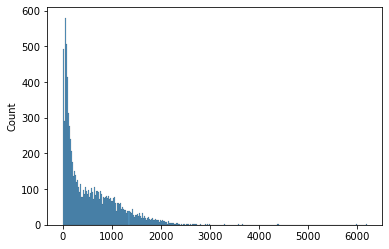

In [64]:
average = []
totlen = len(of.mutation_count_list)
for x in range(0, int(totlen/500)-1):
    average.append(sum(of.mutation_count_list[x*500: x*500 +500]))
sns.histplot(average, bins=300)

In [48]:
def bin_formula(max_bin_counts, tot_bin_counts):
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += c
    if sum(bin_counts) == 0:
        return 2
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [58]:
mutation_bin_probability(of.mutation_count_list[4056047:4056344])

([11, 12, 8], 0.8608652568505617)

In [69]:
organism_name_dict

{'NC_000962.3': 'Mycobacterium tuberculosis H37Rv',
 'NZ_CP102342.1': 'Mycolicibacterium smegmatis',
 'NZ_AP022575.1': 'Mycobacterium shinjukuense',
 'NZ_CP085200.1': 'Mycobacterium ulcerans',
 'NZ_AP022581.1': 'Mycobacterium lacus',
 'NZ_CP092364.1': 'Mycobacterium goodii',
 'NZ_CP058277.1': 'Mycobacterium marinum',
 'NC_022663.1': 'Mycobacterium kansasii ATCC 12478',
 'NZ_LR026975.1': 'Mycolicibacterium hassiacum DSM 44199',
 'NZ_CP074376.1': 'Mycolicibacterium neoaurum',
 'NZ_CP080999.1': 'Mycobacterium malmoense',
 'NZ_AP022569.1': 'Mycobacterium cookii',
 'NZ_AP022596.1': 'Mycolicibacterium helvum',
 'NZ_LR134355.1': 'Mycolicibacterium chitae',
 'NC_014814.1': 'Mycolicibacterium gilvum Spyr1'}

In [ ]:
def produce_non_shadowed_orfs(orfs):
    a = orfs
    a.sort(key = lambda x: x[3], reverse = True)
    orf_list = [a[0]]
    for x in tqdm(a[1:]):
        matched = 0
        for v in orf_list:
            if x[1] > v[0] and x[0]<=v[1]:
                matched = 1
                break
               
        if matched == 0:
            orf_list.append(x)
    orf_list.sort(key = lambda x: x[0])
    return orf_list